In [6]:
import numpy as np
from anony_process_pipeline import *
from src.modules.utils_image import pillow_image_to_bytes, numpy_image_to_pillow
from database_controller import DatabaseController

Configuration chargée et vérifiée.


In [7]:
from werkzeug.datastructures import FileStorage
import os

def import_subject_images(ids):
    image_folder = "../../data/yalefaces"
    sujet = f"subject0{ids}_"
    image_files = []
    for filename in os.listdir(image_folder):
        if filename.startswith(sujet):
            chemin_fichier = f"{image_folder}/{filename}"
            file = open(chemin_fichier, "rb")
            file_storage = FileStorage(stream=file, filename=filename)
            image_files.append(file_storage)
    return image_files

from PIL import Image
from IPython.display import display

def display_images_side_by_side(images, background_color=(255, 255, 255)):
    images = [img.convert('RGB') for img in images]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height), background_color)
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.width
    display(new_im)

from PIL import Image
import base64
import io
import base64
from io import BytesIO
from PIL import Image
import time

def base64_to_pil(b64_string):
    image_data = base64.b64decode(b64_string)
    image = Image.open(io.BytesIO(image_data))
    return image


2025-04-15 14:30:44,109 - INFO - Exécution du pré-traitement standard avec IMAGE_SIZE=(100, 100)...
2025-04-15 14:30:44,109 - INFO - Traitement de 11 fichiers FileStorage.


[<FileStorage: 'subject03_centerlight.png' (None)>, <FileStorage: 'subject03_glasses.png' (None)>, <FileStorage: 'subject03_happy.png' (None)>, <FileStorage: 'subject03_leftlight.png' (None)>, <FileStorage: 'subject03_noglasses.png' (None)>, <FileStorage: 'subject03_normal.png' (None)>, <FileStorage: 'subject03_rightlight.png' (None)>, <FileStorage: 'subject03_sad.png' (None)>, <FileStorage: 'subject03_sleepy.png' (None)>, <FileStorage: 'subject03_surprised.png' (None)>, <FileStorage: 'subject03_wink.png' (None)>]


Preprocessing (FileStorage List): 100%|██████████| 11/11 [00:00<00:00, 217.21it/s]
2025-04-15 14:30:44,166 - INFO - Pré-traitement terminé. 11 images traitées pour 1 sujets.


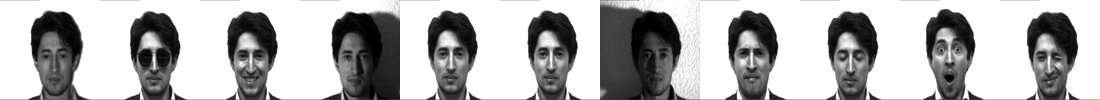

In [8]:
# Import images
img_list = import_subject_images(3)
# Print result
print(img_list)

# ---------------------------------------
# Étape 1 : Preprocessing (Simplifiée)
# ---------------------------------------
image_size = (100, 100)
res1, image_size = run_preprocessing(filestorage_list=img_list, image_size_override=image_size)

# IMG IMPORT ENDING: Realise images in storage ###
for img_in_storage in img_list: ##################
    img_in_storage.close() #######################
##################################################

# Print result
images = res1[list(res1.keys())[0]]
images = [img['normalized_image'] for img in images]
images = numpy_image_to_pillow(images, image_size, True)
display_images_side_by_side(images)

2025-04-15 14:30:46,501 - INFO - Application de K-Same-Pixel avec k=4...
K-Same Pixel: 100%|██████████| 1/1 [00:00<00:00, 249.60it/s]
2025-04-15 14:30:46,511 - INFO - Traitement K-Same-Pixel terminé.


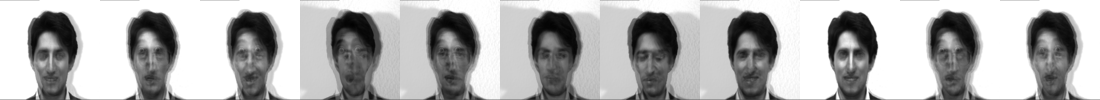

In [9]:
time.sleep(0.1)
# ---------------------------------------
# Étape 2 : K-Same-Pixel (Nouvelle Fonction Modulaire)
# ---------------------------------------
k_same_k_value = 4
res2 = run_k_same_anonymization(res1, k_same_k_value)

# Print result
images = res2[list(res2.keys())[0]]
images = [img['flattened_anonymized_image'] for img in images]
images = numpy_image_to_pillow(images, image_size, True)
display_images_side_by_side(images)

n_components: 8


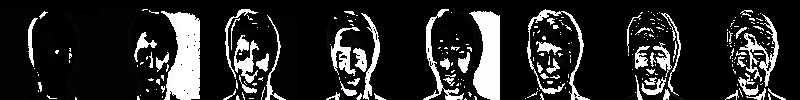

In [10]:
# ---------------------------------------
# Étape 3 : PEEP Eigenface
# ---------------------------------------

flattened_stack_list = [img['flattened_anonymized_image'] for img in res2["upload_subject_1"]]
flattened_stack_np = np.array(flattened_stack_list, dtype=np.float32)

n_samples, n_features = flattened_stack_np.shape
n_components_ratio = 0.8
n_components = min(max(1, int(n_components_ratio * n_samples)), n_features)

res3 = run_eigenface(flattened_stack_np, n_components)

# Print result
pca, mean_face, projection = res3 # Eingenface a disparue...
print("n_components:", n_components)
images = res3[0].components_
images = numpy_image_to_pillow(images, image_size, True)
display_images_side_by_side(images)

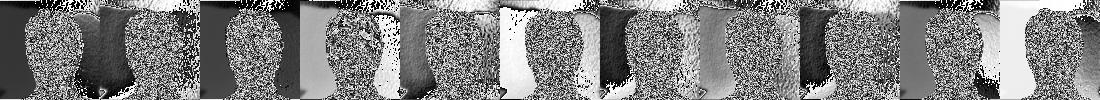

In [11]:
# Étape 4 : Ajout de bruit différentiel
epsilon = 0.01
res4 = run_add_noise(projection, epsilon, sensitivity=1.0)


# Étape 5 : Reconstruction
res5 = run_reconstruction(pca, res4, image_size)

# Print result
imgs = [Image.open(BytesIO(base64.b64decode(img))) for img in res5]
display_images_side_by_side([base64_to_pil(img) for img in res5])


Create db connection at: D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\data\database.db
user_id: 14


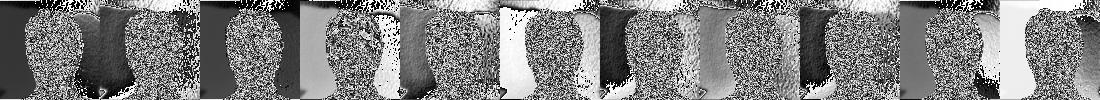

In [12]:
db = DatabaseController(r"..\..\data\database.db")

user_id = db.add_user(np.array(res5))
print(f"user_id: {user_id}")

# Get user db images
user = db.get_user(user_id)

#Print result
display_images_side_by_side([base64_to_pil(img) for img in user])


In [14]:
# Theorie & need parameters modifications
from face_recognition.train import train_model

#
train_model()

from face_recognition.predict import predict_image

prediction = predict_image()
print(f"user detected: {prediction}")


ImportError: Traceback (most recent call last):
  File "C:\myPrograms\Python 3.12\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 70, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Une routine d’initialisation d’une bibliothèque de liens dynamiques (DLL) a échoué.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.